In [1]:
# -------------------------------
#
#        Question 1 
#
# -------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

random = 42

removed_cols = ['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'wheelbase']
cols_to_clean = ['back_legroom', 'height', 'length']
#categorical_columns = ['body_type', 'exterior_color', 'fuel_type', 'wheel_system']
categorical_columns = ['body_type', 'fuel_type']
num_columns = ['back_legroom', 'height', 'highway_fuel_economy', 'horsepower', 'length', 'mileage', 'year', 'age']

def trainData(data):
    #removed_cols = ['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'wheelbase']
    df_train = data.drop(columns=removed_cols)

    df_train['age'] = 2021 - df_train['year']
    df_train.drop(columns='year')

    #cols_to_clean = ['back_legroom', 'height', 'length']

    # Fill missing entries with NaN
    for column in cols_to_clean:
        df_train[column] = df_train[column].replace("--", np.nan).str.replace(" in", "").astype(float)

    # Fill missing entries with the average of the column
    for column in cols_to_clean:
        average_value = df_train[column].mean()
        df_train[column] = df_train[column].fillna(average_value)

    y = df_train['price']  # Target variable
    x = df_train.drop(['price'], axis=1)  # Features

    return x,y

# Step 1: Load and Preprocess Data
data = pd.read_csv('pc3_and_pc4_training_data_large_v1.csv')
X_full, y_full = trainData(data)

#removed_cols = ['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'wheelbase']
#df_train = data.drop(columns=removed_cols)

#df_train['age'] = 2021 - df_train['year']
#df_train.drop(columns='year')

#cols_to_clean = ['back_legroom', 'height', 'length']

# Fill missing entries with NaN
#for column in cols_to_clean:
#    df_train[column] = df_train[column].replace("--", np.nan).str.replace(" in", "").astype(float)

# Fill missing entries with the average of the column
#for column in cols_to_clean:
#    average_value = df_train[column].mean()
#    df_train[column] = df_train[column].fillna(average_value)

# Extract features and target variable
#y_full = df_train['price']  # Target variable
#X_full = df_train.drop(['price'], axis=1)  # Features

In [2]:
print(X_full.shape[1])

10


In [3]:
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_exclude="object")),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

X_transformed = preprocessor.fit_transform(X_full)

In [2]:
labeler = LabelEncoder()

for column in categorical_columns:
    X_full[column] = labeler.fit_transform(X_full[column])

#X_full[categorical_columns] = labeler.fit_transform(X_full[categorical_columns])

#for col in df_train.columns:
#    if (col in categorical_columns):
#        df_train[col] = labeler.fit_transform(df_train[col])

X_transformed = X_full

In [5]:
print(X_transformed.shape[1])

10


In [3]:
# Normialization / Transforming
y_log = np.log1p(y_full)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_log, test_size=0.2, random_state=random)

In [7]:
print(X_train.shape[1])

10


In [4]:
# RANDOM FOREST MODEL WITH LESS FEATURES

check = False

rf_model = RandomForestRegressor(max_features=int(np.sqrt(X_train.shape[1])), max_depth=20, n_estimators=500, random_state=random)

# Hyperparameters to tune using GridSearchCV, search space adjusted through trial and error
param_grid = {
    'max_depth': [None, 15, 20]
}

best_rf_model = rf_model

if (check):
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_rf_model = grid_search.best_estimator_
    print(grid_search.best_params_)
else:
    rf_model.fit(X_train, y_train)
    best_rf_model = rf_model

# Predict on the validation set
y_test_pred = best_rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"RF Regression MSE: {mse}")
print(f"RF Regression R^2: {r2}")


RF Regression MSE: 0.016287631966675473
RF Regression R^2: 0.9504168223259987


In [9]:
# RANDOM FOREST MODEL WITH ALL FEATURES

check = False

bag_model = RandomForestRegressor(max_features=(X_train.shape[1]), max_depth=20, n_estimators=500, random_state=random)

# Define hyperparameters to tune using GridSearchCV
param_grid = {
    'n_estimators': [400, 500, 600]
}

best_bag_model = bag_model

if (check):
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=bag_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_bag_model = grid_search.best_estimator_
    print(grid_search.best_params_)
else:
    bag_model.fit(X_train, y_train)
    best_bag_model = bag_model

# Predict on the validation set
y_test_pred = best_bag_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"RF Full Regression MSE: {mse}")
print(f"RF Full Regression R^2: {r2}")

RF Full Regression MSE: 0.02741304671005607
RF Full Regression R^2: 0.8821600573060274


In [5]:
best_model = best_rf_model

In [6]:
test_data = pd.read_csv('MLforEcon_W2024_pc5_test_with_response.csv')
XTest, yTest = trainData(test_data)

for column in categorical_columns:
    XTest[column] = labeler.fit_transform(XTest[column])

yTest = np.log1p(yTest)

In [7]:
preds = best_model.predict(XTest)
mse = mean_squared_error(yTest, preds)
r2 = r2_score(yTest, preds)
print(f"Full Regression MSE: {mse}")
print(f"Full Regression R^2: {r2}")

Full Regression MSE: 0.021126255438179104
Full Regression R^2: 0.7855237806563733


In [21]:
final_preds = best_model.predict(XTest)
final_preds = pd.DataFrame(final_preds)
final_preds.to_csv("final_preds.csv", index=False, header=False)

In [12]:
data1 = pd.read_csv('MLforEcon_W2024_pc5_train_v1.csv')

x1, y1 = trainData(data1)

for column in categorical_columns:
    x1[column] = labeler.fit_transform(x1[column])

y1_log = np.log1p(y1)

# Split the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1_log, test_size=0.2, random_state=random)

In [13]:
data2 = pd.read_csv('pc3_and_pc4_training_data_small_v1.csv')

x2, y2 = trainData(data2)

for column in categorical_columns:
    x2[column] = labeler.fit_transform(x2[column])

y2_log = np.log1p(y2)

# Split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2_log, test_size=0.2, random_state=random)

In [16]:
best_model.fit(X_train1, y_train1)
print("Trained from PC5 Data")

preds = best_model.predict(X_test1)

mse = mean_squared_error(y_test1, preds)
r2 = r2_score(y_test1, preds)
print("PC5 Tests")
print(f"R^2: {r2}")

preds = best_model.predict(X_test2)

mse = mean_squared_error(y_test2, preds)
r2 = r2_score(y_test2, preds)
print("PC3/4 Tests")
print(f"R^2: {r2}")

PC5 Data
MSE: 0.027508997976021625
R^2: 0.8817475934233228
PC3/4 Data
MSE: 0.07796274858662783
R^2: 0.7656215241936731


In [17]:
best_model.fit(X_train2, y_train2)
print("Trained from PC3/4 Data")

preds = best_model.predict(X_test1)

mse = mean_squared_error(y_test1, preds)
r2 = r2_score(y_test1, preds)
print("PC5 Tests")
print(f"R^2: {r2}")

preds = best_model.predict(X_test2)

mse = mean_squared_error(y_test2, preds)
r2 = r2_score(y_test2, preds)
print("PC3/4 Tests")
print(f"R^2: {r2}")

PC5 Data
MSE: 0.030101345412444778
R^2: 0.8706039187861322
PC3/4 Data
MSE: 0.01956025531120148
R^2: 0.9411962391099132


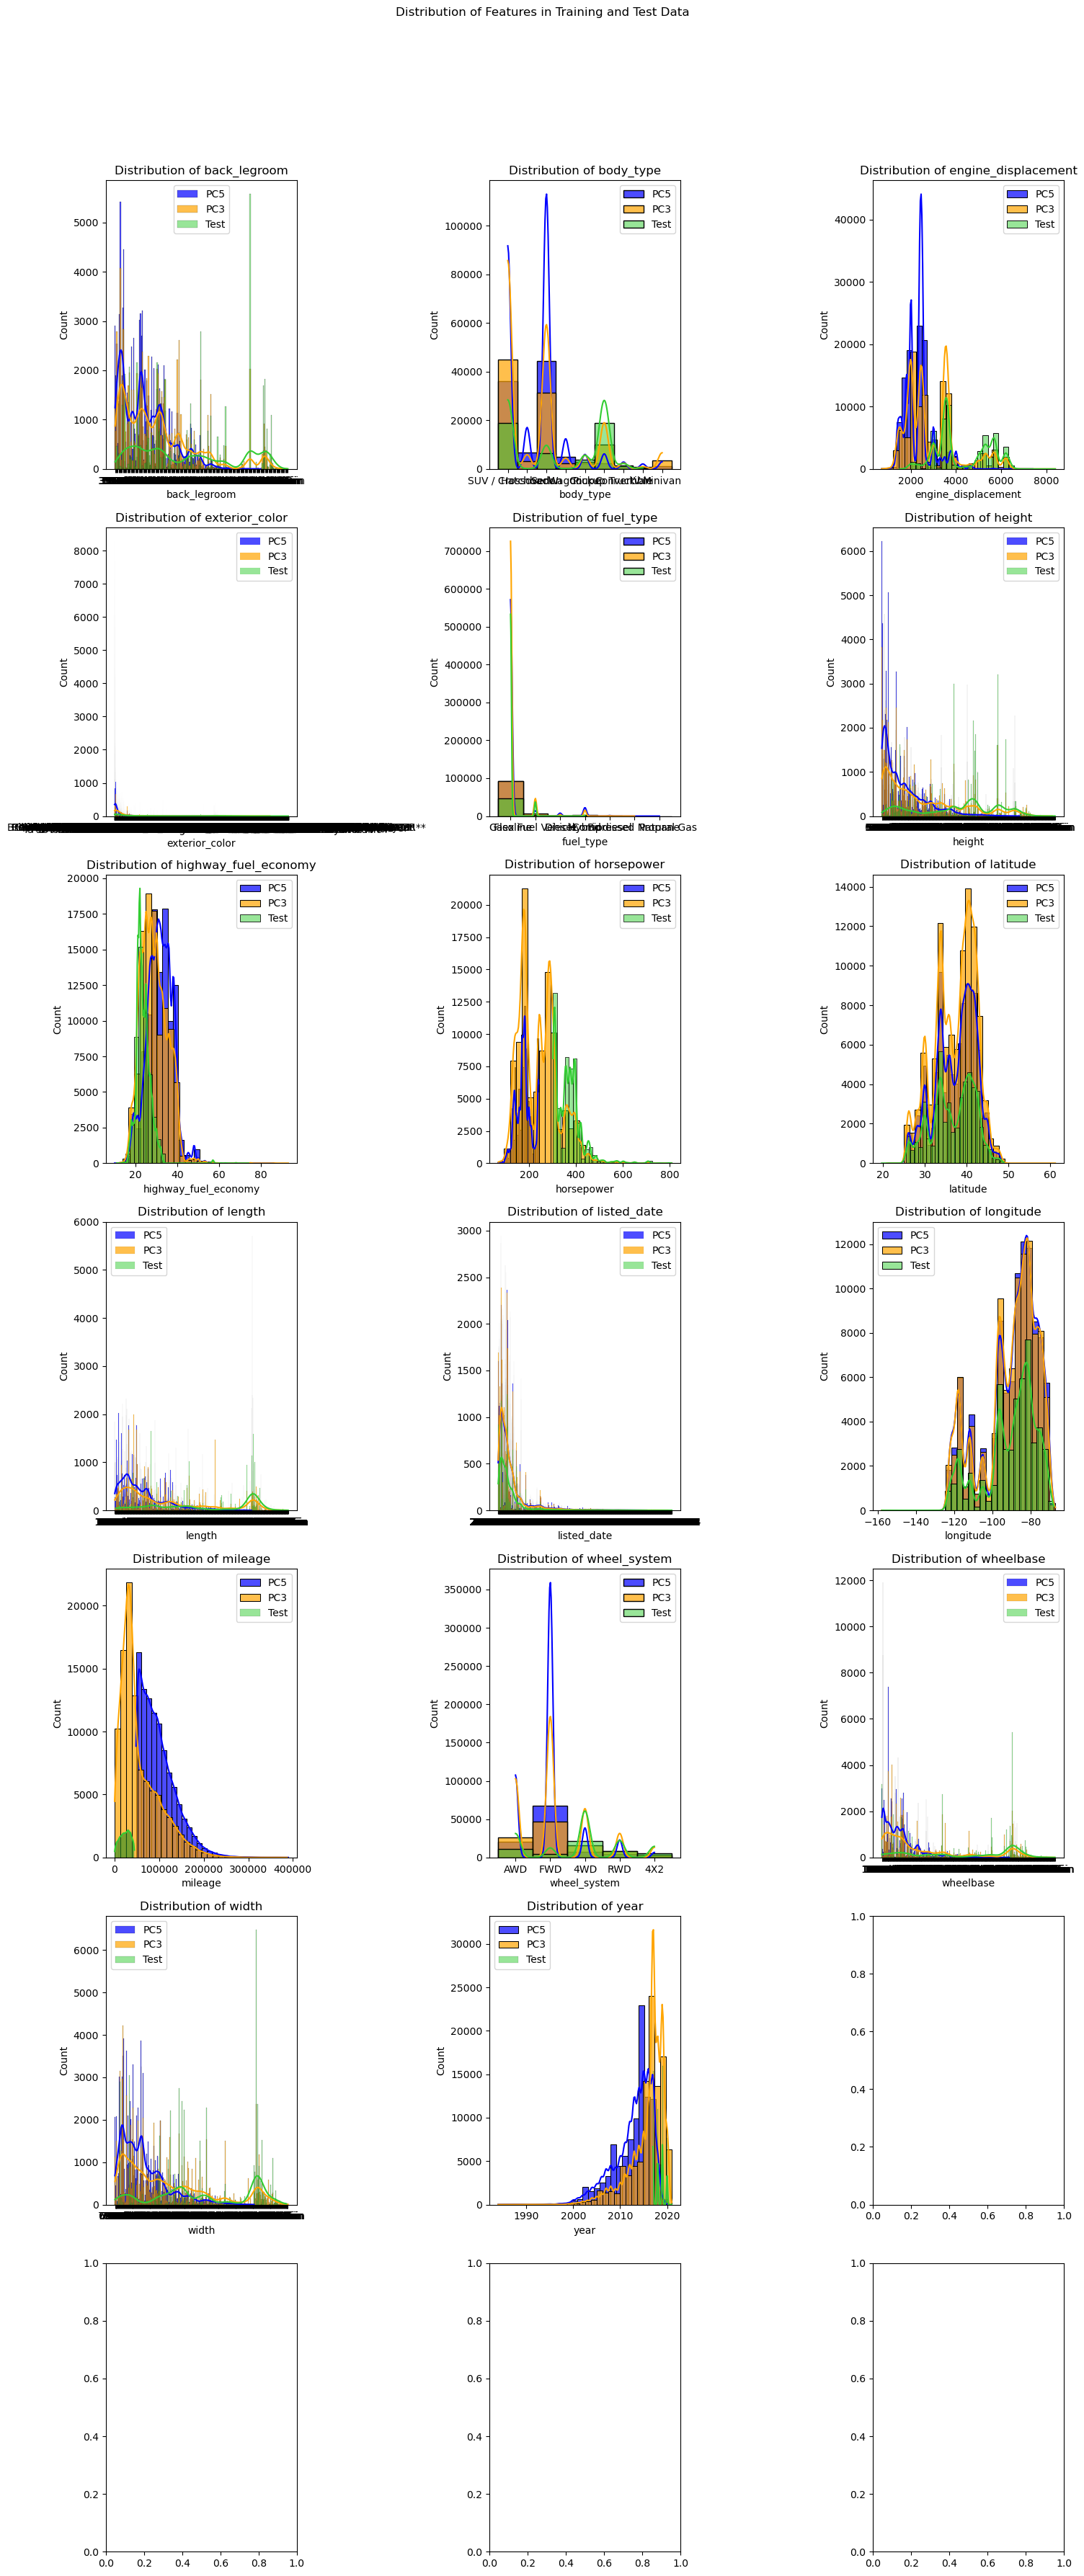

In [20]:
import seaborn as sns


test_obs = test_data.drop(['price'], axis=1)
pc3_obs = data2.drop(['price'], axis=1)
pc5_obs = data1.drop(['price'], axis=1)

# Combine training and test data for visualization
combined_data = pd.concat([pc5_obs, pc3_obs, test_obs], keys=['train1', 'train2', 'Test'])

# Set up subplots for distribution of each feature
num_features = len(test_obs.columns)
num_rows_dist = num_features // 2 + num_features % 2
fig_dist, axes_dist = plt.subplots(num_rows_dist, 2, figsize=(15, 5 * num_rows_dist))
fig_dist.suptitle('Distribution of Features in Training and Test Data', y=1.02)
fig_dist.subplots_adjust(hspace=0.5)

for i, feature in enumerate(test_obs.columns):
    row, col = divmod(i, 2)
    ax = axes_dist[row, col]
    sns.histplot(combined_data.loc['train1', feature], bins=30, kde=True, ax=ax, label='PC5', color='blue', alpha=0.7)
    sns.histplot(combined_data.loc['train2', feature], bins=30, kde=True, ax=ax, label='PC3', color='orange', alpha=0.7)
    sns.histplot(combined_data.loc['Test', feature], bins=30, kde=True, ax=ax, label='Test', color='limegreen', alpha=0.5)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust layout for both plots
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()